In [1]:
import numpy as np
import pandas as pd
import torch, os, cv2
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

### Check images

In [2]:
# https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
IMAGE_ROOT = 'bus-truck/annotations.csv'
DF_RAW = pd.read_csv(IMAGE_ROOT)
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.370000,0.960000,0.167500,0.800000,0,0,...,0,0,0.645625,0.960000,0.746875,0.370000,0.167500,0.700833,0.800000,0.732500


In [3]:
row = DF_RAW.iloc[4]
image = row["ImageID"]
print(image)
img = cv2.imread(os.path.join('bus-truck/images', image +'.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, c = img.shape
print(h, w, c)

00013f14dd4e168f
192 256 3


In [4]:
boxes = row[['XMin', 'YMin', 'XMax', 'YMax']].values
boxes = boxes.astype(np.float32)
boxes_pt = torch.from_numpy(boxes)
boxes_pt

tensor([0.3700, 0.1675, 0.9600, 0.8000])

In [5]:
h, w, c = img.shape
cv2.rectangle(img, (int(boxes[0]*w), int(boxes[1]*h)), (int(boxes[2]*w), int(boxes[3]*h)), (0, 200,0), 2);

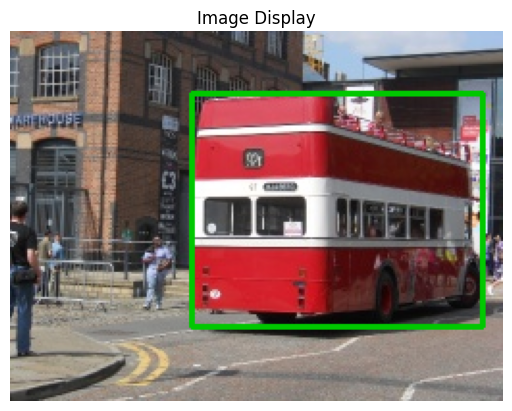

In [6]:
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title('Image Display')
plt.show()

In [7]:
# transform = weights.transforms()
# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor()
# ])

### Training

In [8]:
weights = models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

transform = transforms.ToTensor()
data_label = {'Bus': 1, 'Truck': 2}

In [9]:
class DatasetImages(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.unique_images = df["ImageID"].unique()
    
    def __len__(self):
        return len(self.unique_images)
        
    def __getitem__(self, ix):
        
        image_id = self.unique_images[ix]        
        image = Image.open(os.path.join('bus-truck/images', image_id+'.jpg'))
        image = image.convert("RGB")
        w, h = image.size
        if self.transform:
            image = self.transform(image)
            
        rows = self.df[self.df["ImageID"] == image_id]
        boxes = []
        labels = []
        for _, r in rows.iterrows():
            
            box = r[['XMin', 'YMin', 'XMax', 'YMax']].values
            box = box.astype(np.float32)
    
            xmin = int(box[0]*w)
            ymin = int(box[1]*h)
            xmax = int(box[2]*w)
            ymax = int(box[3]*h)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
            
            class_name = data_label[r["LabelName"]]
            labels.append(class_name)
            
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
                }

        return image, target

In [10]:
len(DF_RAW["ImageID"])
train_data = DF_RAW[0:3000]
test_data = DF_RAW[3000:3600]

test_data.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
3000,1520ee319683bdbe,xclick,Bus,1,0.023750,0.468125,0.027237,0.280934,0,0,...,1,0,0.222500,0.023750,0.200625,0.468125,0.027237,0.111284,0.280934,0.148638
3001,1520ee319683bdbe,xclick,Bus,1,0.044375,0.453125,0.357198,0.621790,0,0,...,1,0,0.310625,0.453125,0.243125,0.044375,0.357198,0.526848,0.621790,0.498054
3002,1520ee319683bdbe,xclick,Bus,1,0.068125,0.420000,0.684825,0.963424,0,0,...,1,0,0.214375,0.068125,0.290000,0.420000,0.684825,0.781323,0.963424,0.843580
3003,1520ee319683bdbe,xclick,Bus,1,0.561875,0.951250,0.013230,0.286381,0,0,...,1,0,0.780000,0.561875,0.725000,0.951250,0.013230,0.155642,0.286381,0.095720
3004,1520ee319683bdbe,xclick,Bus,1,0.580000,0.928125,0.688716,0.963424,0,0,...,1,0,0.729375,0.580000,0.792500,0.928125,0.688716,0.782879,0.963424,0.845136


In [11]:
train_dataset = DatasetImages(train_data, transform)
test_dataset = DatasetImages(test_data, transform)

In [12]:
def collate_fn(batch):
    # [(1,1), (2,2)]
    '''a list of images and a list of target dictionaries'''
    return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=4, collate_fn=collate_fn)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3050 6GB Laptop GPU'

In [14]:
model = models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)

In [15]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 3

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
for params in model.backbone.parameters():
    params.requires_grad = False

model.to(device)
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0004)
print(len(train_dataloader))
print(len(test_dataloader))

464
98


In [18]:
EPOCHS = 4
total_loss = []
total_loss_test = []

model.train()
for epoch in range(EPOCHS):
    print(f"\nEpoch: {epoch+1}")
    
    batch_loss = 0
    b_count = 0
    
    for batch in train_dataloader:
        b_count += 1
        X, y = batch
        images = [img.to(device) for img in X]
        targets = [{k:v.to(device) for k,v in t.items()} for t in y]
        
        loss_dict = model(images, targets)
        # print("tr", loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        # print("11111")
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        # print("22222")
        batch_loss += losses.item()
        print(f"{b_count=} of {len(train_dataloader)}")
        # break
    total_loss.append(batch_loss/b_count)

    b_count = 0
    batch_loss = 0
    # model.eval()
    for batch in test_dataloader:
        b_count += 1
        X, y = batch

        with torch.no_grad():

            images = [img.to(device) for img in X]
            targets = [{k:v.to(device) for k,v in t.items()} for t in y]
            
            loss_dict = model(images, targets)
            # print("ts", loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            # print("22222")
            batch_loss += losses.item()
            print(f"{b_count=} of {len(test_dataloader)}")
            # break
    total_loss_test.append(batch_loss/b_count)


print()
print(total_loss)
print(total_loss_test)


Epoch: 1
b_count=1 of 464
b_count=2 of 464
b_count=3 of 464
b_count=4 of 464
b_count=5 of 464
b_count=6 of 464
b_count=7 of 464
b_count=8 of 464
b_count=9 of 464
b_count=10 of 464
b_count=11 of 464
b_count=12 of 464
b_count=13 of 464
b_count=14 of 464
b_count=15 of 464
b_count=16 of 464
b_count=17 of 464
b_count=18 of 464
b_count=19 of 464
b_count=20 of 464
b_count=21 of 464
b_count=22 of 464
b_count=23 of 464
b_count=24 of 464
b_count=25 of 464
b_count=26 of 464
b_count=27 of 464
b_count=28 of 464
b_count=29 of 464
b_count=30 of 464
b_count=31 of 464
b_count=32 of 464
b_count=33 of 464
b_count=34 of 464
b_count=35 of 464
b_count=36 of 464
b_count=37 of 464
b_count=38 of 464
b_count=39 of 464
b_count=40 of 464
b_count=41 of 464
b_count=42 of 464
b_count=43 of 464
b_count=44 of 464
b_count=45 of 464
b_count=46 of 464
b_count=47 of 464
b_count=48 of 464
b_count=49 of 464
b_count=50 of 464
b_count=51 of 464
b_count=52 of 464
b_count=53 of 464
b_count=54 of 464
b_count=55 of 464
b_count=5

In [19]:
save_path = "fasterrcnn_resnet50_fpn_v2.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to fasterrcnn_resnet50_fpn_v2.pth


In [1]:
def fc(**kwargs):
    print(kwargs)
fc(a=2, b=1)

{'a': 2, 'b': 1}


In [2]:
def fc(*args):
    print(args)
fc(2, 1, 5)

(2, 1, 5)


In [3]:
def fc(args):
    print(list(zip(*args)))
fc([(1,2), (1,2), (1,2)])

[(1, 1, 1), (2, 2, 2)]


In [4]:
for z in zip((1, 1, 1), (2, 2, 2)):
    print(z)

(1, 2)
(1, 2)
(1, 2)


---

In [29]:
import torchvision

# Load the v2 model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
model.train()
# Check if any BatchNorm layers are frozen
for name, module in model.named_modules():
    if "BatchNorm" in module.__class__.__name__:
        if hasattr(module, 'weight') and module.weight.requires_grad is False:
            print(f"{name} is frozen")

backbone.body.bn1 is frozen
backbone.body.layer1.0.bn1 is frozen
backbone.body.layer1.0.bn2 is frozen
backbone.body.layer1.0.bn3 is frozen
backbone.body.layer1.0.downsample.1 is frozen
backbone.body.layer1.1.bn1 is frozen
backbone.body.layer1.1.bn2 is frozen
backbone.body.layer1.1.bn3 is frozen
backbone.body.layer1.2.bn1 is frozen
backbone.body.layer1.2.bn2 is frozen
backbone.body.layer1.2.bn3 is frozen
